### To-Do
- Sample Background noise and incorperate it into models
- Change models to TensorFlow

In [1]:
# Load Kaggle API Token
from google.colab import files
!pip install -q kaggle > /dev/null
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Load Data
!kaggle competitions download -c tensorflow-speech-recognition-challenge > /dev/null

# Unzip Data
!apt-get install p7zip-full > /dev/null
!p7zip -d train.7z > /dev/null
# !p7zip -d test.7z > /dev/null

Saving kaggle.json to kaggle.json
100% 501k/501k [00:00<00:00, 76.8MB/s]
100% 50.0/50.0 [00:00<00:00, 50.3kB/s]
100% 2.46G/2.46G [01:02<00:00, 42.2MB/s]
100% 1.04G/1.04G [00:21<00:00, 51.7MB/s]


In [2]:
# from scipy.io import wavfile
from IPython.display import Audio
from os import walk
from matplotlib import pyplot as plt

debug = False

train_audio_path = '/content/train/audio/'

# Load all filenames into a dictionary so we can call on them easily
files = {}
for (dirpath, dirnames, filenames) in walk(train_audio_path):
  files[dirpath[21:]] = filenames

files.pop('')
files['_background_noise_'].remove('README.md')
if debug:
  # Look at dataset size
  count = 0
  for label, samples in files.items():
    print(label, '\t', len(samples))
    count += len(samples)

  print("Number of Audio signals:", count)

### Useful Imports and Functions

In [3]:
import librosa
import librosa.display
from scipy import signal
import numpy as np
from keras import backend as K
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import time

Using TensorFlow backend.


In [4]:
def get_wav(file_name, nsamples=16000):
  wav = wavfile.read(file_name)[1]
  if wav.size < nsamples:
      d = np.pad(wav, (nsamples - wav.size, 0), mode='constant')
  else:
      d = wav[0:nsamples]
  return d

In [5]:
def loadData(files):
  # Build Dataset
  xtrain, ytrain = [], []
  for label, filenames in files.items():
    if label not in ['', '_background_noise_']:
      for filename in filenames:
        audio = get_wav(train_audio_path + label + '/' + filename)
        
        xtrain.append(audio)
        ytrain.append(label)
        
  return np.array(xtrain).astype(np.float32), np.array(ytrain)

In [6]:
def calculateMFCCs(xtrain):
  MFCCs = []
  rate = 16000
  for audio in xtrain:
    mfcc = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc = 50, n_mels=128)
    MFCCs.append(mfcc.T)

  return np.array(MFCCs)

In [7]:
def calculateSpectograms(xtrain):
  spectograms = []
  rate = 16000
  for audio in xtrain:
    _, _, spectogram = log_specgram(audio, sample_rate=rate)
    spectograms.append(spectogram.T)

  return np.array(spectograms)

In [8]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [9]:
def normalize(x):
  minX = np.amin(x)
  maxX = np.amax(x)
  gap = maxX - minX

  return (x - (minX + 0.5*gap)) / (0.5 * gap)

In [10]:
def f1(y_true, y_pred):
  """Macro F1 Score

  A custom metric function that computes the average of the f1 scores 
  across all classesin a multiclass classificaiton problem
  """
  def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision * recall)/(precision + recall + K.epsilon()))

In [11]:
def onehot(A, mapping=None):
  labels = set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown'])

  if mapping is None:
    mapping = {}
    maptolable = {}
    for i, label in enumerate(labels):
      temp = [0] * len(labels)
      temp[i] = 1
      mapping[label] = temp
      maptolable[i] = label
      
  res = []
  for label in A:
    if label == '_background_noise_':
      res.append(mapping['silence'])
    elif label in labels:
      res.append(mapping[label])
    else:
      res.append(mapping['unknown'])
  
  return np.array(res), mapping, maptolable

In [12]:
def performance_curves(history, metrics):
  def generate_plot(metric):
    train = history.history[metric]
    val = history.history['val_' + metric]
    x_axis = range(1, len(history.history[metric])+1)

    plt.figure()
    plt.plot(x_axis, train, label="Training " + metric)
    plt.plot(x_axis, val, label="Validation " + metric)

    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.title('Epochs vs ' + metric)
    plt.legend()
    plt.show()

    if metric == 'loss':
      print('Minimum Validation Loss is:', str(min(val)))
      print('Epoch: ', str(val.index(min(val)) + 1))
    else:
      print('Maximum', metric, 'is:', str(max(val)))
      print('Epoch: ', str(val.index(max(val)) + 1))
  
  for metric in ['loss'] + metrics:
    generate_plot(metric)

In [17]:
import IPython.display as ipd
window_size = 1000
subSampleLength = 16000
noise = []
count = 0
for filename in files['_background_noise_']:
  sample_rate, audio = wavfile.read(train_audio_path + '_background_noise_' + '/' + 'white_noise.wav')
  # print(len(audio))
  for i in range((len(audio)-subSampleLength) // window_size):
    start = i*window_size
    subsample = audio[start: start + subSampleLength]
    noise.append(subsample)

    if len(subsample) != 16000:
      count += 1
  # print(count)


# []n

# n/1000 chuncks of size 16000

# print((960000 -16000)/1000)

0
0
0
0
0
0
944.0


## LSTM vs. CNN (Raw Audio)

In [ ]:
X, Y = loadData(files)

### LSTM

In [ ]:
Xfinal = X.reshape(-1, 16000, 1)
Yonehot, mapping, maptolable = onehot(Y)

xtrain, xval, ytrain, yval = train_test_split(Xfinal, Yonehot, test_size=0.2, random_state=127)

In [ ]:
print('Number of Dimensions:', X.ndim)
print('Dataset')
print('\t', Xfinal.shape, '\t', Yonehot.shape)

print('\nTraining Data')
print('\t', xtrain.shape, '\t', ytrain.shape)

print('\nValidation Data')
print('\t', xval.shape, '\t', yval.shape)

Number of Dimensions: 2
Dataset
	 (64721, 16000, 1) 	 (64721, 12)

Training Data
	 (51776, 16000, 1) 	 (51776, 12)

Validation Data
	 (12945, 16000, 1) 	 (12945, 12)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten, Dropout, BatchNormalization, Conv1D, MaxPool1D

model = Sequential()

model.add(LSTM(32, input_shape = xtrain.shape[1:], activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# model.add(LSTM(64, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(len(mapping), activation = 'softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                780       
Total params: 7,372
Trainable params: 7,308
Non-trainable params: 64
___________________________________________________

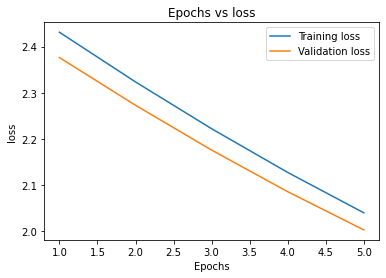

Minimum Validation Loss is: 2.0026544251834255
Epoch:  5


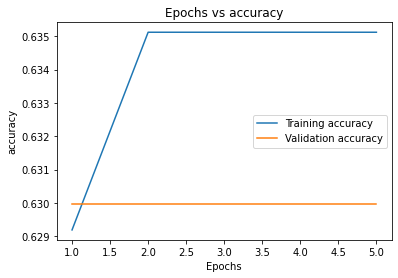

Maximum accuracy is: 0.6299729347229004
Epoch:  1


In [ ]:
history = model.fit(xtrain, ytrain, batch_size=512, validation_data=(xval, yval), epochs=1, shuffle=True, verbose=0)
performance_curves(history, ['accuracy'])

### CNN

In [ ]:
Xfinal = X.reshape(-1, 16000, 1)

Yonehot, mapping, maptolable = onehot(Y)
Yonehot = Yonehot.reshape(-1, 1, 12)

xtrain, xval, ytrain, yval = train_test_split(Xfinal, Yonehot, test_size=0.2, random_state=127)

In [ ]:
print('Number of Dimensions:', X.ndim)
print('Dataset')
print('\t', Xfinal.shape, '\t', Yonehot.shape)

print('\nTraining Data')
print('\t', xtrain.shape, '\t', ytrain.shape)

print('\nValidation Data')
print('\t', xval.shape, '\t', yval.shape)

Number of Dimensions: 2
Dataset
	 (64721, 16000, 1) 	 (64721, 1, 12)

Training Data
	 (51776, 16000, 1) 	 (51776, 1, 12)

Validation Data
	 (12945, 16000, 1) 	 (12945, 1, 12)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import TensorBoard

model = Sequential()
model.add(Conv1D(32, kernel_size=10, strides = 4, activation = 'relu', input_shape = xtrain.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=10, strides = 4, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=10, strides = 4, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=10, strides = 4, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(len(mapping), activation = 'softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1, 'accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3998, 32)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 3998, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1999, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1999, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 498, 64)           20544     
_________________________________________________________________
batch_normalization_2 (Batch (None, 498, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 166, 64)          

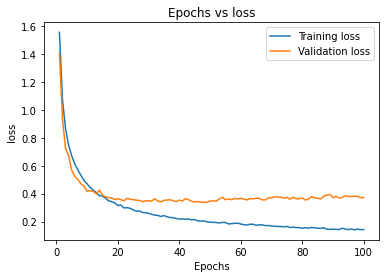

Minimum Validation Loss is: 0.3382588897906201
Epoch:  48


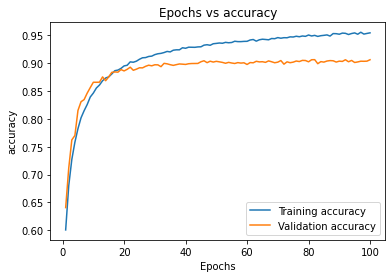

Maximum accuracy is: 0.9062185883522034
Epoch:  82


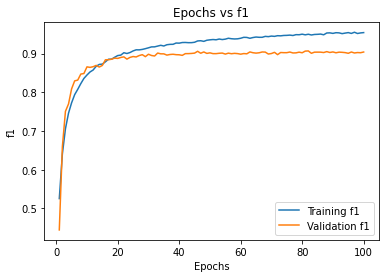

Maximum f1 is: 0.9070141911506653
Epoch:  82


In [ ]:
history = model.fit(xtrain, ytrain, batch_size=512, validation_data=(xval, yval), epochs=100, shuffle=True, verbose=0)
performance_curves(history, ['accuracy', 'f1'])

## Spectogram vs. MFCCs

In [ ]:
MFCCs = calculateMFCCs(X)
Spectograms = calculateSpectograms(X)

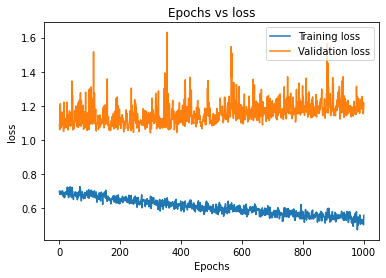

Minimum Validation Loss is: 1.041746973991394
Epoch:  300


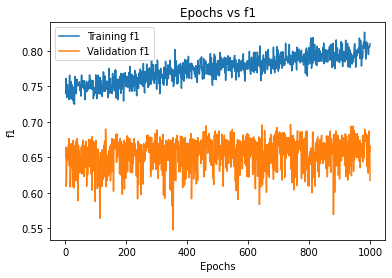

Maximum f1 is: 0.6962698698043823
Epoch:  739


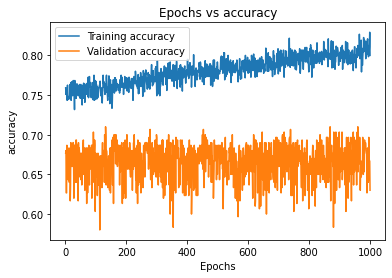

Maximum accuracy is: 0.7099999785423279
Epoch:  132


In [ ]:
# Using MFCCs
history = model.fit(xtrain, ytrain, batch_size=512, validation_data=(xval, yval), epochs=1000, shuffle=True, verbose=0)
performance_curves(history, ['f1', 'accuracy'])

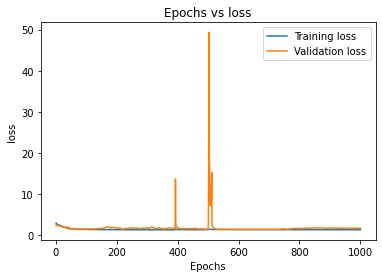

Minimum Validation Loss is: 1.4572668075561523
Epoch:  606


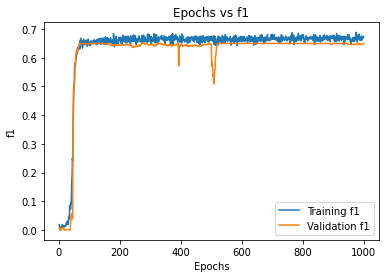

Maximum f1 is: 0.6521008014678955
Epoch:  278


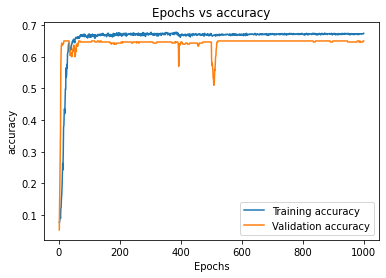

Maximum accuracy is: 0.6499999761581421
Epoch:  16


In [ ]:
# Using Spectograms
history = model.fit(xtrain, ytrain, batch_size=512, validation_data=(xval, yval), epochs=1000, shuffle=True, verbose=0)
performance_curves(history, ['f1', 'accuracy'])